In [ ]:
!pip install streamlit -q

In [ ]:
!pip install requests -q

In [ ]:
import requests
from bs4 import BeautifulSoup
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import pandas as pd
import random
from time import sleep
import numpy as np
import re
import streamlit as st

In [ ]:
# Headers to mimic a real browser request
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/135.0.0.0 Safari/537.36 Edg/135.0.0.0",
    "Accept-Language": "en-US, en;q=0.5"
}

def get_title(soup):
    """Extract the product title from HTML"""
    try:
        title = soup.find("span", {"id": "productTitle"})
        return title.text.strip() if title else ""
    except:
        return ""

def get_price(soup):
    """Extract the product price from HTML"""
    try:
        price = soup.find("span", {"class": "a-offscreen"})
        return price.text.strip() if price else ""
    except:
        return ""

def get_rating(soup):
    """Extract the product rating (e.g., '4.7')"""
    try:
        rating = soup.find("span", {"class": "a-icon-alt"})
        return rating.text.strip().split()[0] if rating else ""
    except:
        return ""

def get_review_count(soup):
    """Extract the number of reviews"""
    try:
        reviews = soup.find("span", {"id": "acrCustomerReviewText"})
        return reviews.text.strip() if reviews else ""
    except:
        return ""

def get_availability(soup):
    """Check if product is in stock"""
    try:
        availability = soup.find("div", {"id": "availability"})
        return availability.text.strip() if availability else "Out of Stock"
    except:
        return "Out of Stock"

def safe_request(url, max_retries=3):
    """Send a GET request with retry logic and error handling"""
    for attempt in range(max_retries):
        try:
            response = requests.get(url, headers=HEADERS, timeout=10)
            if response.status_code == 200:
                return response
            sleep(random.uniform(3, 6))  # Random delay
        except requests.exceptions.RequestException:
            sleep(random.uniform(5, 8))
    return None

def scrape_amazon_products(search_query, num_pages=3):
    """
    Main function to scrape Amazon products based on search query

    Parameters:
        search_query (str): Product name to search on Amazon
        num_pages (int): Number of pages to scrape (default: 3)

    Returns:
        pd.DataFrame: DataFrame containing scraped data
    """
    formatted_query = search_query.replace(" ", "+")
    base_url = f"https://www.amazon.com/s?k={formatted_query}"

    data = []

    page_number = 1
    while page_number <= num_pages:
        url = f"{base_url}&page={page_number}"
        response = safe_request(url)

        if not response:
            break

        soup = BeautifulSoup(response.content, "html.parser")

        # Find all product containers
        product_containers = soup.find_all("div", {"data-asin": True})
        if not product_containers:
            break

        for container in product_containers:
            asin = container["data-asin"]
            product_url = f"https://www.amazon.com/dp/{asin}"

            # Scrape individual product page
            product_response = safe_request(product_url)
            if not product_response:
                continue

            product_soup = BeautifulSoup(product_response.content, "html.parser")

            # Extract product details
            title = get_title(product_soup)
            price = get_price(product_soup)
            rating = get_rating(product_soup)
            reviews = get_review_count(product_soup)
            availability = get_availability(product_soup)

            # Only add valid, in-stock products
            if title and price and rating and reviews and availability != "Out of Stock":
                data.append({
                    "title": title,
                    "price": price,
                    "rating": rating,
                    "reviews": reviews,
                    "availability": availability
                })

        page_number += 1
        sleep(random.uniform(2, 5))

    # Save results
    if data:
        df = pd.DataFrame(data)
        df.to_csv(f"amazon_{formatted_query}.csv", index=False)
        return df
    else:
        return pd.DataFrame()  # Return empty DataFrame if no data

In [ ]:
if __name__ == "__main__":
    query = input("Enter product to search on Amazon: ").strip()
    result_df = scrape_amazon_products(query)

In [ ]:
df = pd.read_csv("amazon_headphones.csv")

In [ ]:
# Print how many products were loaded
print("Loaded", len(df), "products")

# Show first 5 rows to inspect the data
df.head()

Loaded 70 products


,title,price,rating,reviews,availability
0,TOZO E2 Wireless Earbuds 10mm Drivers with Pow...,$9.99,4.6,952 ratings,In Stock
1,TOZO E1 Wireless Earbuds Build in Mic Clear Ca...,$13.99,4.7,617 ratings,In Stock
2,"TOZO OpenEgo True Wireless Open Ear Headphone,...",$29.99,4.3,"2,987 ratings",In Stock
3,JBL Tune 510BT - Bluetooth headphones with up ...,$29.95,4.5,"75,100 ratings",In Stock
4,Apple EarPods Headphones with Lightning Connec...,$15.96,4.6,"8,989 ratings",In Stock


In [ ]:
# Function to extract only numeric value from price (e.g., "$299.99" → 299.99)
def clean_price(price):
    try:
        # Use regex to extract number from price string
        return float(re.search(r'\d+[\d,.]*', str(price)).group(0).replace(',', ''))
    except:
        # If price can't be cleaned, return NaN
        return np.nan

# Apply the function to 'price' column
df['price_clean'] = df['price'].apply(clean_price)

# Show original vs cleaned price
df[['price', 'price_clean']].head()

,price,price_clean
0,$9.99,9.99
1,$13.99,13.99
2,$29.99,29.99
3,$29.95,29.95
4,$15.96,15.96


In [ ]:
# Function to extract only the first number from rating (e.g., "4.7 out of 5" → 4.7)
def clean_rating(rating):
    try:
        # Split string by spaces and take the first part (the actual rating)
        return float(str(rating).split()[0])
    except:
        # If rating is invalid, return NaN
        return np.nan

# Apply it to 'rating' column
df['rating_clean'] = df['rating'].apply(clean_rating)

# Show original vs cleaned rating
df[['rating', 'rating_clean']].head()

,rating,rating_clean
0,4.6,4.6
1,4.7,4.7
2,4.3,4.3
3,4.5,4.5
4,4.6,4.6


In [ ]:
# Function to extract only the number from review count (e.g., "15,423 ratings" → 15423)
def clean_reviews(reviews):
    try:
        # Remove commas, split by spaces, take first part, convert to int
        return int(str(reviews).replace(',', '').split()[0])
    except:
        # If can't parse, return NaN
        return np.nan

# Apply it to 'reviews' column
df['reviews_clean'] = df['reviews'].apply(clean_reviews)

# Show original vs cleaned reviews
df[['reviews', 'reviews_clean']].head()

,reviews,reviews_clean
0,952 ratings,952
1,617 ratings,617
2,"2,987 ratings",2987
3,"75,100 ratings",75100
4,"8,989 ratings",8989


In [ ]:
# Keep only products with "stock" in availability (case-insensitive match)
df = df[df['availability'].str.contains('stock', case=False, na=True)]

# Drop any products with missing price, rating, or reviews
df_clean = df.dropna(subset=['price_clean', 'rating_clean', 'reviews_clean'])

# Print how many valid products remain
print("✅ After filtering:", len(df_clean), "valid products")

# Show cleaned data
df_clean.head()

✅ After filtering: 70 valid products


,title,price,rating,reviews,availability,price_clean,rating_clean,reviews_clean
0,TOZO E2 Wireless Earbuds 10mm Drivers with Pow...,$9.99,4.6,952 ratings,In Stock,9.99,4.6,952
1,TOZO E1 Wireless Earbuds Build in Mic Clear Ca...,$13.99,4.7,617 ratings,In Stock,13.99,4.7,617
2,"TOZO OpenEgo True Wireless Open Ear Headphone,...",$29.99,4.3,"2,987 ratings",In Stock,29.99,4.3,2987
3,JBL Tune 510BT - Bluetooth headphones with up ...,$29.95,4.5,"75,100 ratings",In Stock,29.95,4.5,75100
4,Apple EarPods Headphones with Lightning Connec...,$15.96,4.6,"8,989 ratings",In Stock,15.96,4.6,8989


In [ ]:
# Normalize price: lower price = higher score (1 - (x - min)/(max - min))
df_clean['price_norm'] = 1 - (df_clean['price_clean'] - df_clean['price_clean'].min()) / (df_clean['price_clean'].max() - df_clean['price_clean'].min())

# Normalize rating: higher rating = higher score
df_clean['rating_norm'] = (df_clean['rating_clean'] - df_clean['rating_clean'].min()) / (df_clean['rating_clean'].max() - df_clean['rating_clean'].min())

# Normalize reviews: more reviews = higher score
df_clean['reviews_norm'] = (df_clean['reviews_clean'] - df_clean['reviews_clean'].min()) / (df_clean['reviews_clean'].max() - df_clean['reviews_clean'].min())

In [ ]:
# Set weights based on your new 30-50-20 strategy
WEIGHT_PRICE = 0.3     # Price contributes 30%
WEIGHT_RATING = 0.5    # Rating contributes 50%
WEIGHT_REVIEWS = 0.2   # Reviews contribute 20%

# Composite score: higher score = better product
df_clean['score'] = (
    WEIGHT_PRICE * df_clean['price_norm'] +
    WEIGHT_RATING * df_clean['rating_norm'] +   # Make sure this is 'rating_norm', not 'rating_clean'
    WEIGHT_REVIEWS * df_clean['reviews_norm']
)

# Sort by score (descending)
ranked_df = df_clean.sort_values(by='score', ascending=False).head(10)

# Show final top products
ranked_df[['title', 'price_clean', 'rating_clean', 'reviews_clean', 'score']]

,title,price_clean,rating_clean,reviews_clean,score
6,"Wireless Earbuds, Sports Bluetooth Headphones,...",22.78,4.9,1425,0.791193
7,"Sony ZX Series Wired On-Ear Headphones, Black ...",12.88,4.5,122317,0.746110
23,Kids Headphones - noot products K11 Foldable S...,13.99,4.7,40200,0.740301
15,Beats Solo3 Wireless On-Ear Headphones - Apple...,114.95,4.6,83256,0.684509
1,TOZO E1 Wireless Earbuds Build in Mic Clear Ca...,13.99,4.7,617,0.684265
20,TOZO E1 Wireless Earbuds Build in Mic Clear Ca...,13.99,4.7,617,0.684265
39,TOZO E1 Wireless Earbuds Build in Mic Clear Ca...,13.99,4.7,617,0.684265
5,Soundcore Anker Life Q20 Hybrid Active Noise C...,39.99,4.5,85987,0.678250
33,Sony MDR7506 Professional Large Diaphragm Head...,98.00,4.7,26554,0.670068
3,JBL Tune 510BT - Bluetooth headphones with up ...,29.95,4.5,75100,0.668922


In [ ]:
ranked_df = df_clean.sort_values(by='score', ascending=False).head(10)
ranked_df = ranked_df.reset_index(drop=True)

# Add contribution columns for visualization
ranked_df['Price'] = ranked_df['price_norm'] * WEIGHT_PRICE
ranked_df['Rating'] = ranked_df['rating_norm'] * WEIGHT_RATING
ranked_df['Reviews'] = ranked_df['reviews_norm'] * WEIGHT_REVIEWS



<ipython-input-17-13105e785c96>:12: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


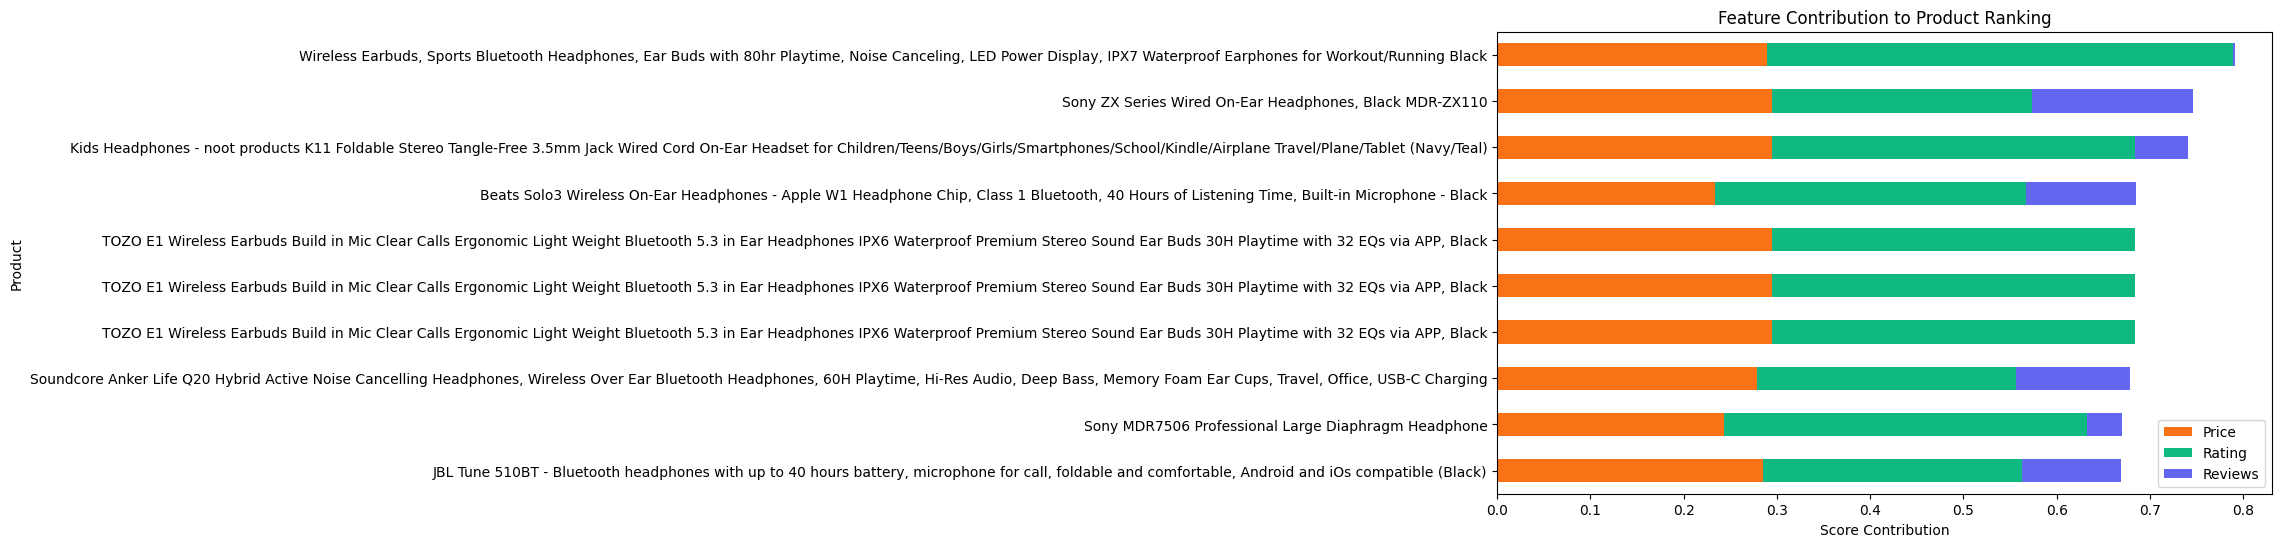

In [ ]:

# Plot stacked bar chart
ranked_df.set_index('title')[['Price', 'Rating', 'Reviews']].plot(
    kind='barh',
    stacked=True,
    figsize=(10, 6),
    color=['#f97316', '#10b981', '#6366f1'],
    title="Feature Contribution to Product Ranking"
)
plt.xlabel("Score Contribution")
plt.ylabel("Product")
plt.gca().invert_yaxis()  # Show highest scorer on top
plt.tight_layout()
plt.show()

In [ ]:
ranked_df[['title', 'price_clean', 'rating_clean', 'reviews_clean', 'score']]
df = pd.DataFrame(ranked_df)
df.to_csv(f"ranked_products_pt.csv", index=False)

In [ ]:
from IPython.display import display

# Define custom styling for visual clarity
styled_df = ranked_df[['title', 'price_clean', 'rating_clean', 'reviews_clean', 'score']].style.background_gradient(cmap='Blues', subset=['score']) \
                                                    .background_gradient(cmap='Greens', subset=['rating_clean']) \
                                                    .background_gradient(cmap='Oranges', subset=['price_clean']) \
                                                    .highlight_max(subset=['score'], color='lightgreen') \
                                                    .format({'price_clean': '${:.2f}', 'score': '{:.3f}'})

display(styled_df)

,title,price_clean,rating_clean,reviews_clean,score
0,"Wireless Earbuds, Sports Bluetooth Headphones, Ear Buds with 80hr Playtime, Noise Canceling, LED Power Display, IPX7 Waterproof Earphones for Workout/Running Black",$22.78,4.900000,1425,0.791
1,"Sony ZX Series Wired On-Ear Headphones, Black MDR-ZX110",$12.88,4.500000,122317,0.746
2,Kids Headphones - noot products K11 Foldable Stereo Tangle-Free 3.5mm Jack Wired Cord On-Ear Headset for Children/Teens/Boys/Girls/Smartphones/School/Kindle/Airplane Travel/Plane/Tablet (Navy/Teal),$13.99,4.700000,40200,0.740
3,"Beats Solo3 Wireless On-Ear Headphones - Apple W1 Headphone Chip, Class 1 Bluetooth, 40 Hours of Listening Time, Built-in Microphone - Black",$114.95,4.600000,83256,0.685
4,"TOZO E1 Wireless Earbuds Build in Mic Clear Calls Ergonomic Light Weight Bluetooth 5.3 in Ear Headphones IPX6 Waterproof Premium Stereo Sound Ear Buds 30H Playtime with 32 EQs via APP, Black",$13.99,4.700000,617,0.684
5,"TOZO E1 Wireless Earbuds Build in Mic Clear Calls Ergonomic Light Weight Bluetooth 5.3 in Ear Headphones IPX6 Waterproof Premium Stereo Sound Ear Buds 30H Playtime with 32 EQs via APP, Black",$13.99,4.700000,617,0.684
6,"TOZO E1 Wireless Earbuds Build in Mic Clear Calls Ergonomic Light Weight Bluetooth 5.3 in Ear Headphones IPX6 Waterproof Premium Stereo Sound Ear Buds 30H Playtime with 32 EQs via APP, Black",$13.99,4.700000,617,0.684
7,"Soundcore Anker Life Q20 Hybrid Active Noise Cancelling Headphones, Wireless Over Ear Bluetooth Headphones, 60H Playtime, Hi-Res Audio, Deep Bass, Memory Foam Ear Cups, Travel, Office, USB-C Charging",$39.99,4.500000,85987,0.678
8,Sony MDR7506 Professional Large Diaphragm Headphone,$98.00,4.700000,26554,0.670
9,"JBL Tune 510BT - Bluetooth headphones with up to 40 hours battery, microphone for call, foldable and comfortable, Android and iOs compatible (Black)",$29.95,4.500000,75100,0.669


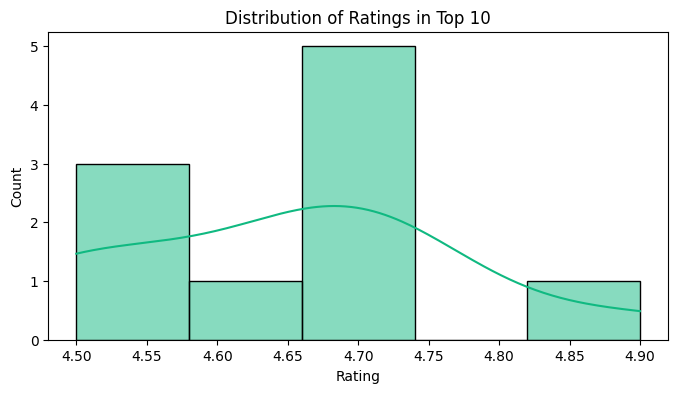

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(ranked_df['rating_clean'], bins=5, kde=True, color="#10b981")
plt.title("Distribution of Ratings in Top 10")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

In [22]:
! pip install streamlit -q


In [23]:
!wget -q -O - ipv4.icanhazip.com


34.57.234.134


In [24]:
! streamlit run app.py & npx localtunnel --port 8501



⠙⠹⠸⠼
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.57.234.134:8501

⠴⠦⠧⠇your url is: https://purple-frogs-argue.loca.lt
  Stopping...
^C
